# <center> **Coded Apertures: 2D Image Recostruction Test**<center>

**Libraries**

In [16]:
# import unittest
import collections.abc as c

import numpy as np
from sympy import nextprime
from matplotlib.colors import ListedColormap
from scipy.signal import correlate

import plot_module as plot

np.set_printoptions(precision=2, suppress=False)

## **1D Folded URA/MURA Masks**

**URA/MURA Pattern Simulation**

In [2]:
class Mask_Pattern:
    """
    Simulates a 2D (n x n) URA/MURA pattern and its decoding
    function from a folded 1D sequence for a coded-mask camera.
    """

    def __init__(self, n: int):
        
        self.n = n
    

    def ura_pattern(self) -> tuple[c.Sequence, c.Sequence]:
        """Generates a folded URA mask pattern and its decoder."""
        
        root = nextprime(self.n**2)
        flag = np.round(((root - 3)/4) - ((root - 3)/4)) == 0

        if not flag:
            raise ValueError(f"length {self.n} not in URA sequences.")
        
        a = np.zeros(root)
        r = (np.arange(root)**2) % root
        a[r] = 1

        g = 2*a - 1

        return tuple(map(lambda x: np.reshape(x[:self.n ** 2], (self.n, self.n)).astype(int), [a, g]))


    def mura_pattern(self) -> tuple[c.Sequence, c.Sequence]:
        """Generates a folded MURA mask pattern and its decoder."""
        
        root = nextprime(self.n**2)
        flag = np.round(((root - 1)/4) - ((root - 1)/4)) == 0

        if not flag:
            raise ValueError(f"length {self.n} not in MURA sequences.")
        
        a = np.zeros(root)
        r = (np.arange(root)**2) % root
        a[r] = 1

        g = 2*a - 1

        a[0], g[0] = 0, 1

        return tuple(map(lambda x: np.reshape(x[:self.n ** 2], (self.n, self.n)).astype(int), [a, g]))

In [57]:
n = 19
flag = False

A_ura, G_ura = Mask_Pattern(n).ura_pattern()
A_mura, G_mura = Mask_Pattern(n).mura_pattern()

if flag:
    plot.image_plot([A_ura, G_ura],
                ["URA Mask Pattern", "URA Mask Decoder"],
                cbarlabel=["Aperture", None],
                cbarcmap=[ListedColormap(["DodgerBlue", "DeepSkyBlue"]), ListedColormap(["DeepPink", "Orange"])])

    plot.image_plot([A_mura, G_mura],
                ["MURA Mask Pattern", "MURA Mask Decoder"],
                cbarlabel=["Aperture", None],
                cbarcmap=[ListedColormap(["DodgerBlue", "DeepSkyBlue"]), ListedColormap(["DeepPink", "Orange"])])

    plot.image_plot([correlate(A_ura, G_ura, mode='full'), correlate(A_ura, G_ura, mode='same')],
                ["A*G mode='full'", "A*G mode='same'"],
                cbarlabel=["Correlation Value", "Correlation Value"],
                cbarcmap=[None, None])

**Mask Interface**

In [3]:
class Coded_Mask_Interface(Mask_Pattern):
    """Interface for the URA/MURA coded mask camera analysis."""
    
    def __init__(self,
                 n: int,
                 sky_image: c.Sequence,
                 pattern_type: str):
        
        self.n = n
        self.pattern_type = pattern_type

        self.mask, self.decoder = self.pattern(pattern_type)
        self.open_fraction = self.mask.sum()/n**2

        self.sky_image = sky_image
        self.detector_image = None
        self.reconstructed_sky = None
    

    def pattern(self, pattern_type: str) -> tuple[c.Sequence, c.Sequence]:
        """Generates the mask pattern."""

        if pattern_type not in ['ura', 'mura']:
            raise ValueError(f"Invalid pattern_type '{pattern_type}', must be 'ura' or 'mura'.")
        
        elif pattern_type == 'ura':
            return self.ura_pattern()
        
        else:
            return self.mura_pattern()
    

    def psf(self) -> c.Sequence:
        """Returns the mask PSF."""

        return correlate(self.mask, self.decoder, mode='same')
    

    def encode(self, detector_background_rate: None | float = None) -> c.Sequence:
        """Returns the detector image from the simulated sky image."""
        
        self.detector_image = correlate(self.mask, self.sky_image, mode='same')

        if detector_background_rate:
            self.detector_image += np.random.poisson(detector_background_rate,
                                                     self.detector_image.shape)
        
        return self.detector_image


    def decode(self) -> c.Sequence:
        """Returns the reconstructed sky image from the detector image."""
        
        rec_sky = correlate(self.decoder, self.detector_image, mode='same')
        self.reconstructed_sky = rec_sky/self.mask.sum()

        return self.reconstructed_sky
    

    def snr(self) -> c.Sequence:
        """Returns the SNR for the reconstructed image."""

        return self.reconstructed_sky/np.sqrt(np.abs(self.reconstructed_sky.sum()))
    

    @property
    def mask_shape(self):
        return self.mask.shape
    
    @property
    def sky_image_shape(self):
        return self.sky_image.shape
    
    @property
    def decoder_shape(self):
        return self.decoder.shape
    
    @property
    def detector_image_shape(self):
        return self.detector_image.shape

In [116]:
cai = Coded_Mask_Interface(19, np.array([0, 3, 0, 6]), 'mura')

cai.n, cai.pattern_type, cai.mask
cai.decoder, cai.open_fraction, cai.mask.shape
cai.psf(), cai.psf().shape
cai.mask_shape, cai.sky_image_shape

((19, 19), (4,))

**Sky Simulation**

In [4]:
def simulate_sky_image(n: int,
                       sources_flux: c.Sequence[int],
                       sources_pos: None | c.Sequence[tuple[int, int]] = None,
                       sky_background_rate: None | int = None,
                       ) -> c.Sequence | tuple[c.Sequence, c.Sequence]:
    """Simulates the sky image given the sources flux."""

    sky_image = np.zeros((n, n))

    # assign fluxes to point-like sources
    for i, pos in enumerate(sources_pos):
        sky_image[pos[0], pos[1]] = sources_flux[i]

    # add sky background
    if sky_background_rate is not None:
        sky_background = np.random.poisson(sky_background_rate, (n, n))
        sky_image += sky_background

    else:
        sky_background = None
    
    return sky_image, sky_background

In [17]:
n = 40
sources_flux = [50, 30, 40]
sources_pos = [(20, 30), (10, 20), (30, 10)]
sky_background_rate=5

flag = False

S1, _ = simulate_sky_image(n, sources_flux)
S2, _ = simulate_sky_image(n, sources_flux, sources_pos)
S3, sky_B3 = simulate_sky_image(n, sources_flux, sources_pos, sky_background_rate)

if flag:
    plot.image_plot([S1, S2, S3, sky_B3],
                    ["S1", "S2", "S3", "sky_B3"],
                    cbarcmap=[None]*4)

**Sky Reconstruction Simulation**

In [5]:
def simulation_routine(n: int,
                       sources_flux: c.Sequence[int],
                       m: int,
                       pattern_type: str,
                       sky_background_rate: None | int = None,
                       sources_pos: None | c.Sequence[tuple[int, int]] = None,
                       detector_background_rate: None | float = None,
                       print_info: bool = False,
                       ) -> tuple[c.Sequence, c.Sequence, dict]:
    """Simulates the reconstruction of the sky for a coded mask camera."""
    
    # sky image simulation
    if not sources_pos:
        sources_pos = [(np.random.randint(0, n), np.random.randint(0, n)) for _ in range(len(sources_flux))]

    sky_image, sky_background = simulate_sky_image(n, sources_flux, sources_pos,
                                                   sky_background_rate)

    # mask initialization
    cai = Coded_Mask_Interface(m, sky_image, pattern_type)
    detector_image = cai.encode(detector_background_rate)

    # sky image reconstruction
    sky_reconstruction = cai.decode()

    # source info
    source_info = {'sources_pos': sources_pos,
                   'sources_transmitted_flux': cai.open_fraction*sources_flux,
                   'sky_image_shape': cai.sky_image_shape,
                   'sky_image': sky_image,
                   'sky_background': sky_background,
                   'sky_reconstruction_SNR': cai.snr(),
                   'mask_pattern': cai.mask,
                   'mask_PSF': cai.psf()}
    
    # print mask info
    if print_info: _print_info(cai)

    return detector_image, sky_reconstruction, source_info


def _print_info(obj) -> None:
    print(f"Mask pattern type: {obj.pattern_type.upper()}\n",
          f"Mask shape: {obj.mask_shape}\n",
          f"Decoder shape: {obj.decoder_shape}\n",
          f"Detector image shape: {obj.detector_image_shape}")

In [6]:
def wrap_sources(sky_reconstruction: c.Sequence,
                 source_pos: c.Sequence) -> c.Sequence:
    """Wraps the fluxes of the reconstructed sources."""

    reconstr_sources = np.array([sky_reconstruction[x[0], x[1]] for x in source_pos])

    return reconstr_sources


**Tests**

In [7]:
class TestReconstruction:

    def __init__(self, pattern_type: str):
        self.pattern_type = pattern_type.upper()

    def test_sky_reconstruction(self,
                                sky_reconstruction: c.Sequence,
                                sky_image: c.Sequence,
                                tolerance: int) -> bool:
        """Tests the whole sky image reconstruction wrt the simulated sky."""

        test = bool(np.all(self._is_close(sky_reconstruction, sky_image, tolerance)))

        print(f"#### {self.pattern_type} Coded Mask Sky Reconstruction Test ####")
        print(f"|S_hat - S| < {tolerance} : {test}\n")

        return test


    def test_sources_reconstruction(self,
                                    reconstr_sources: c.Sequence,
                                    simul_sources: c.Sequence,
                                    tolerance: int) -> bool:
        """Tests the sources reconstructed intensity wrt the simulated ones."""
        
        test = self._is_close(reconstr_sources, simul_sources, tolerance)

        print(f"#### {self.pattern_type} Coded Mask Sources Intensity Reconstruction Test ####")
        for i in range(len(reconstr_sources)):
            print(f"|S_hat[{i}] - S[{i}]| < {tolerance} : {test[i]}")

        return test


    def _is_close(self, S_hat, S, eps) -> c.Sequence[bool]:
        return np.abs(S_hat - S) <= eps

### **URA Mask Pattern**

In [27]:
n = 11
sources_flux = np.array([50, 30])
m = n
pattern_type = 'ura'
sky_background_rate = 2
sources_pos = [(2, 3), (7, 4)]
detector_background_rate = None
print_info = True

In [28]:
args = (n, sources_flux, m, pattern_type, sky_background_rate, sources_pos, detector_background_rate, print_info)
detector_image, sky_reconstruction, source_info = simulation_routine(*args)

Mask pattern type: URA
 Mask shape: (11, 11)
 Decoder shape: (11, 11)
 Detector image shape: (11, 11)


In [29]:
ts = TestReconstruction(pattern_type='ura')

# sky image reconstruction test
sky_image_tol = 5
sky_test = ts.test_sky_reconstruction(sky_reconstruction, source_info['sky_image'], sky_image_tol)

# sources intensity reconstruction
sources_tol = 5
reconstr_sources = wrap_sources(sky_reconstruction, sources_pos)

sources_test = ts.test_sources_reconstruction(reconstr_sources, sources_flux, sources_tol)

#### URA Coded Mask Sky Reconstruction Test ####
|S_hat - S| < 5 : False

#### URA Coded Mask Sources Intensity Reconstruction Test ####
|S_hat[0] - S[0]| < 5 : True
|S_hat[1] - S[1]| < 5 : False


In [ ]:
import importlib
importlib.reload(plot)

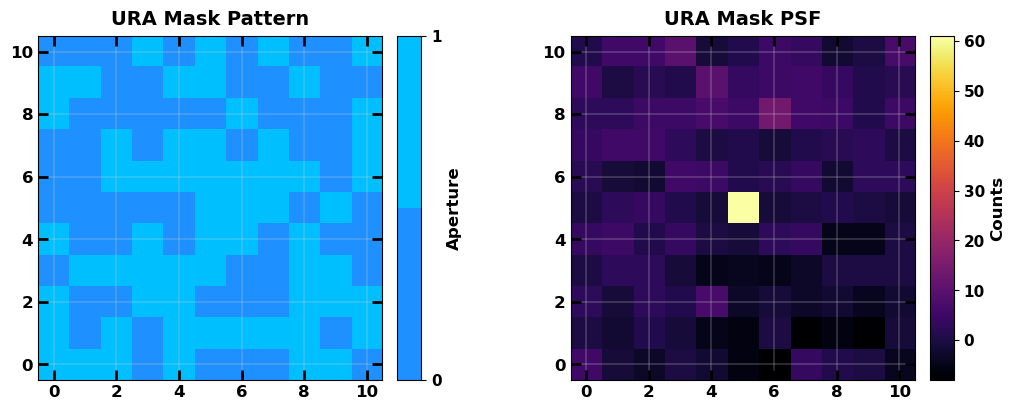

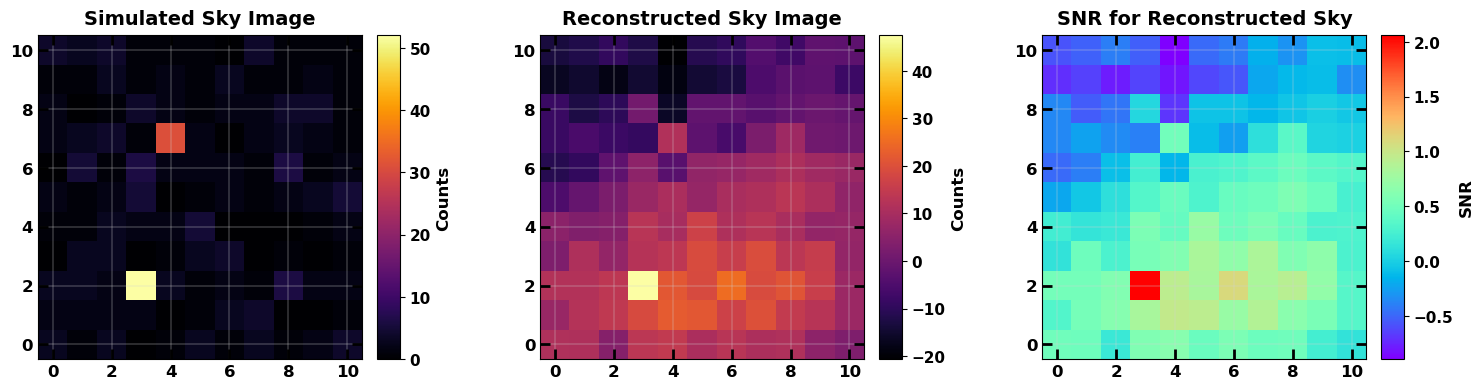

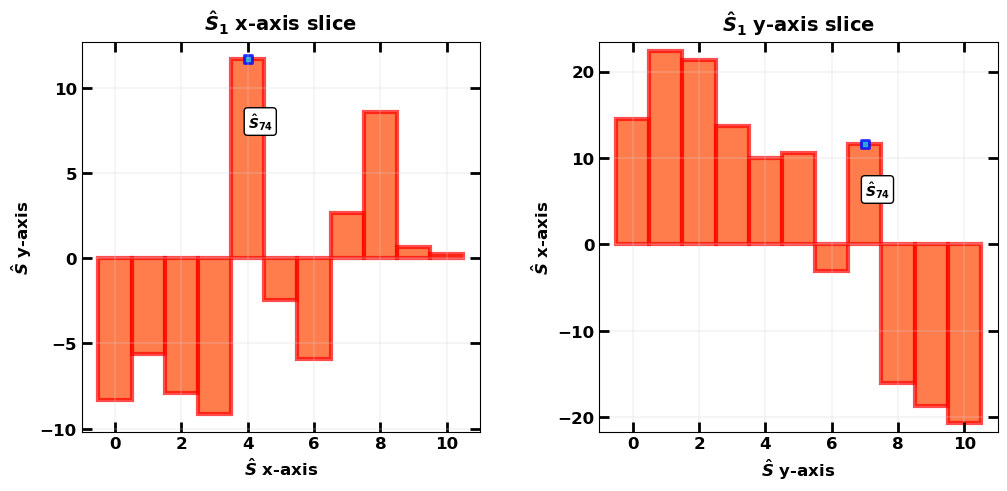

In [30]:
# plot mask, decoder
plot.image_plot([source_info['mask_pattern'], source_info['mask_PSF']],
                ["URA Mask Pattern", "URA Mask PSF"],
                cbarlabel=["Aperture", "Counts"],
                cbarvalues=[[0, 1], None],
                cbarcmap=[ListedColormap(["DodgerBlue", "DeepSkyBlue"]), "inferno"])

# plot simul_sky, reconstr_sky, SNR
lim_inf = min(source_info['sky_image'].min(), sky_reconstruction.min())
lim_sup = max(source_info['sky_image'].max(), sky_reconstruction.max())
spacing = int((lim_sup - lim_inf)//7)

plot.image_plot([source_info['sky_image'], sky_reconstruction, source_info['sky_reconstruction_SNR']],
                ["Simulated Sky Image", "Reconstructed Sky Image", "SNR for Reconstructed Sky"],
                cbarlabel=["Counts"]*2 + ["SNR"],
                cbarvalues=[None]*3,
                cbarcmap=["inferno"]*2 + ["rainbow"])

# plot reconstr_sky slices
idx = 1
pos = source_info['sources_pos'][idx]
S_hat_slicex = sky_reconstruction[pos[0], :]
S_hat_slicey = sky_reconstruction[:, pos[1]]

plot.sequence_plot([S_hat_slicex, S_hat_slicey],
                   [f"$\\hat{{S}}_{idx}$ x-axis slice", f"$\\hat{{S}}_{idx}$ y-axis slice"],
                   xlabel=["$\\hat{{S}}$ x-axis", "$\\hat{{S}}$ y-axis"],
                   ylabel=["$\\hat{{S}}$ y-axis", "$\\hat{{S}}$ x-axis"],
                   style=["bar"]*2,
                   simulated_sources=[(pos[1], *pos, -4), (pos[0], *pos, -6)])




### **MURA Mask Pattern**